In [1]:
import numpy as np
import os
os.chdir('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/')
import argparse
import utils as autils
from utils import DUST_TYPES
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

--------------------------------------------------------------------------
detected:

  Local host:            cpu-r-5
  Device name:           mlx5_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4129

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cpu-r-5
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
dict_plot = {}
dict_plot['GAL040'] = {'linestyle': 'dotted', 'label': 'ACT 40\%'}
dict_plot['GAL060'] = {'linestyle': 'dashed', 'label': 'ACT 60\%'}
dict_plot['GAL070'] = {'linestyle': 'solid', 'label': 'ACT 70\%'}
dict_plot['GAL080'] = {'linestyle': 'dotted', 'label': 'ACT 80\%'}

dict_plot['lmin10'] = {'linestyle': 'dotted', 'label': r'$\ell_{\textrm{min}} = 10$'}
dict_plot['lmin100'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{min}} = 100$'}
dict_plot['lmin600'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{min}} = 600$'}
dict_plot['lmax3000'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{max}} = 3000$'}
dict_plot['lmax3500'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{max}} = 3500$'}

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

dict_plot['gauss'] = {'color': colors[0], 'label': 'Gaussian field'}
dict_plot['d9'] = {'color': colors[1], 'label': 'PySM d9'}
dict_plot['d10'] = {'color': colors[2], 'label': 'PySM d10'}
dict_plot['d12'] = {'color': colors[3], 'label': 'PySM d12'}
dict_plot['DF'] = {'color': colors[4], 'label': 'DUSTFILAMENTS'}
dict_plot['van'] = {'color': colors[5], 'label': 'Vansyngel+17'}

In [3]:
args = argparse.Namespace()

args.mlmax=4000

args.width_ra=15
args.width_dec=10

# args.lmax=3000
# args.lmin=600
args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4

args.nsims_mf=50

args.est= 'TT'
args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'

In [4]:
# signal
lk, clkk=np.loadtxt('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/sslp/extra/clkk_raw_plikHM_TTTEEE_lowl_lowE_dr6_accuracy.txt',unpack=True)
clpp = clkk * 4 / (lk * (lk+1))**2

/tmp/ipykernel_452376/621840297.py:3: RuntimeWarning: invalid value encountered in divide
  clpp = clkk * 4 / (lk * (lk+1))**2


In [5]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
lcut = 500
nbands = 100
lbands = np.concatenate((np.linspace(2, lcut)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands+1)))#  dtype=int)

In [6]:
npatches = {}
for skyfrac in autils.FSKYS:
    npatches[skyfrac] = np.load(args.output_dir + f'local_masks/submap_coordinates_{skyfrac}_{args.width_ra}_{args.width_dec}.npy').shape[0]
print(npatches)

{'GAL060': 111, 'GAL070': 118, 'GAL080': 133}


In [42]:
def args_baseline(args, skyfrac, dust_type):
    
    args.lmax=3000
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

def args_lmin(args, lmin, dust_type, skyfrac='GAL070'):
    
    args.lmax=3000
    args.lmin=lmin
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

def args_lmax(args, lmax, dust_type, skyfrac='GAL070'):
    
    args.lmax=lmax
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

In [8]:
path_recons = lambda ipatch, args, tag, mf: args.output_dir + f'stage_reconstruction/{autils.get_recons_name(ipatch, args, tag, mf)}'

In [9]:
raw_4pt = {}
rawmf_4pt = {}
n0_4pt = {}
reconstructed_cl = {}
cl_nobias = {}

for skyfrac in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        for test in ['baseline', 'lmin', 'lmax']:
            
            raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [10]:
TEST='baseline'

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=False))
            rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=True))
            n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'N0', mf=False))

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for SKYFRAC in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_452376/3812127360.py:17: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [30]:
# SKYFRAC = 'GAL060'
# TEST='lmin'
# dust_type='d9'
# lmin=10

# for n in range(npatches[SKYFRAC]):
#     for dust_type in autils.DUST_TYPES:
#         raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=False))
#         rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=True))
#         n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'N0', mf=False))


# for n in range(npatches[SKYFRAC]):
#     for dust_type in autils.DUST_TYPES:
#         cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

# for dust_type in autils.DUST_TYPES:
#     reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

In [29]:
SKYFRAC = 'GAL070'
TEST='lmax'
lmax=3500

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=False))
        rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=True))
        n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'N0', mf=False))

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for dust_type in autils.DUST_TYPES:
    reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_452376/2161484618.py:18: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


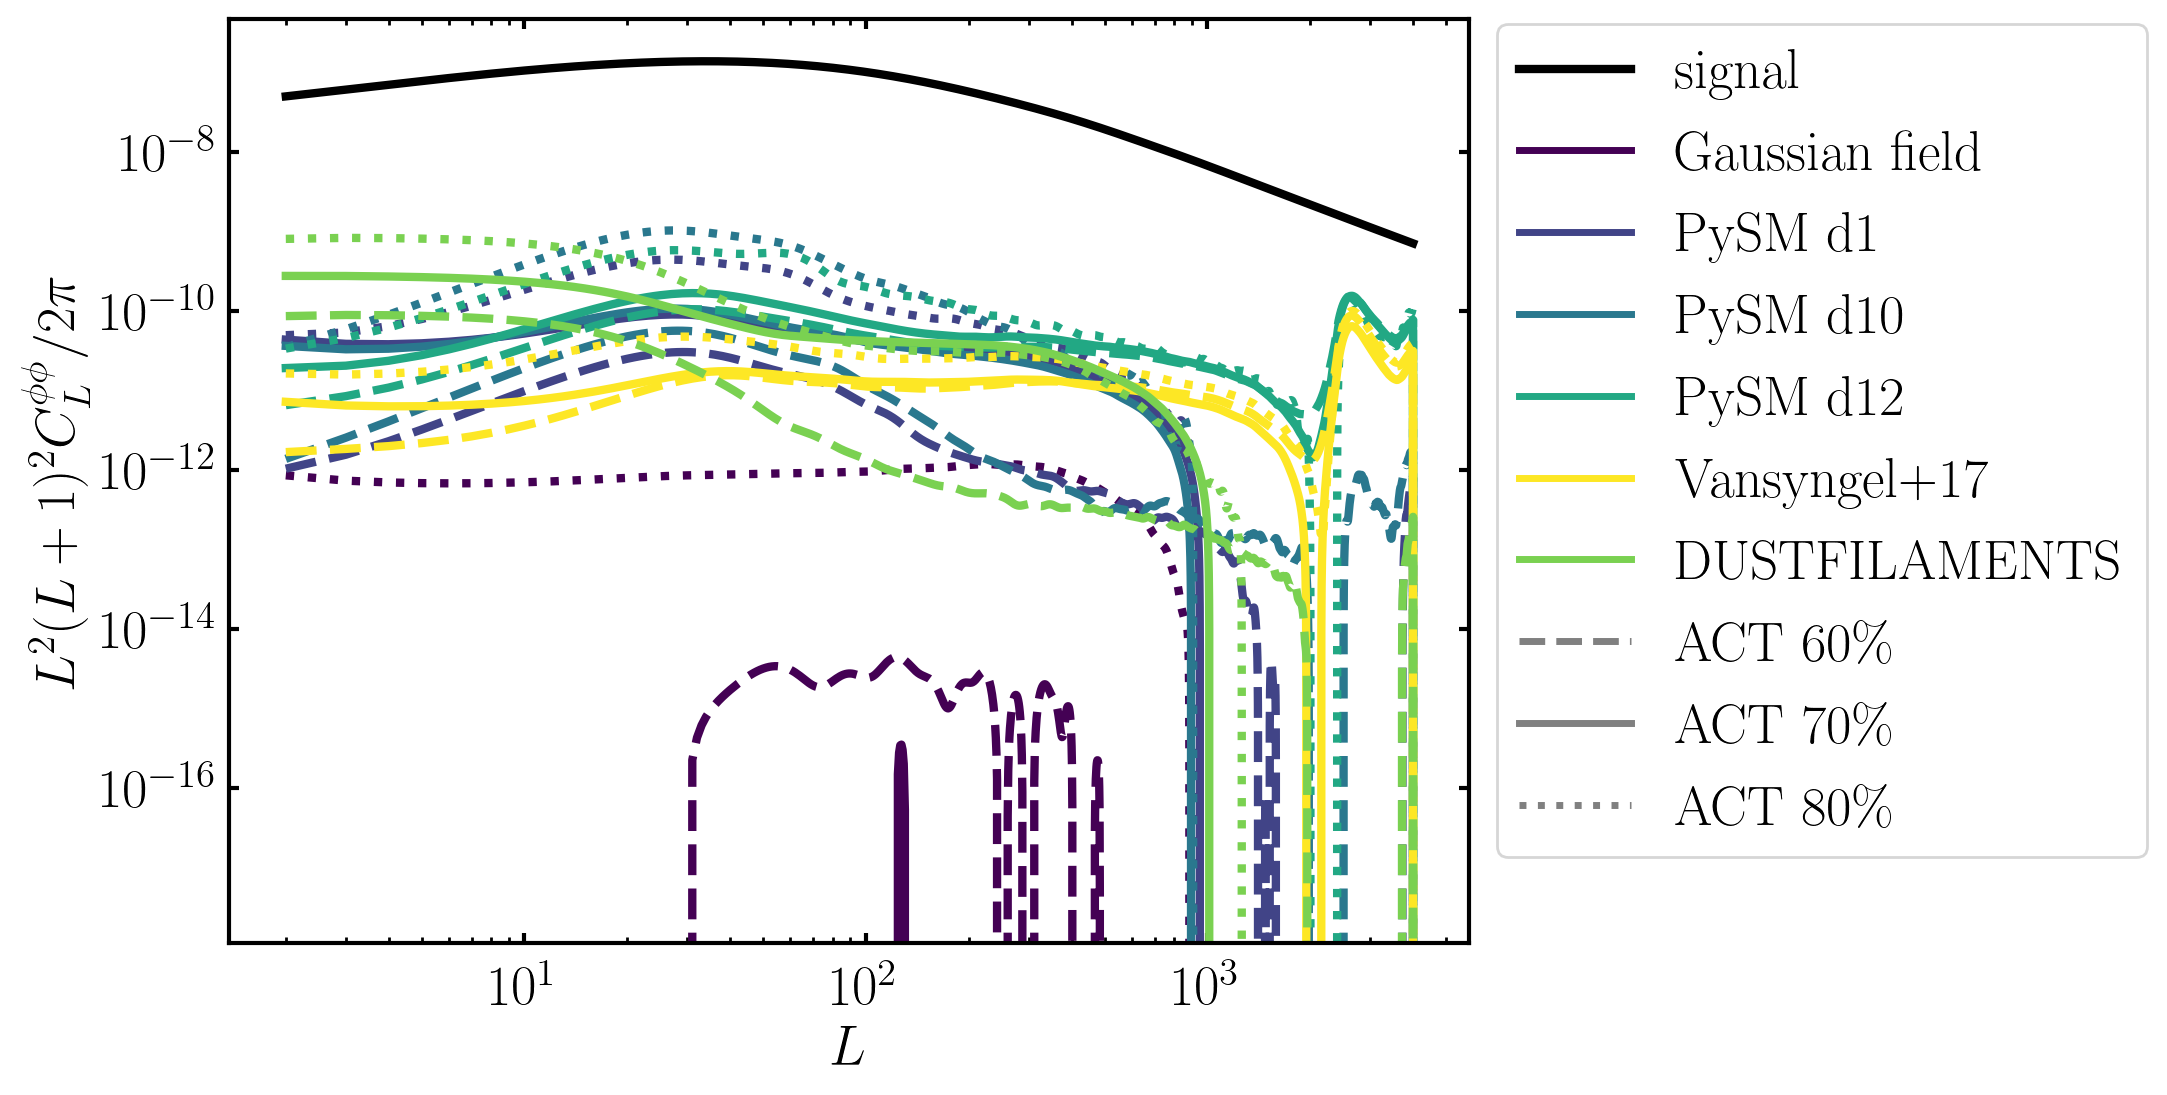

In [43]:
TEST='baseline'
SKYFRAC = 'GAL060'
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

for dust_type in autils.DUST_TYPES:
    for SKYFRAC in autils.FSKYS:
        ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)

    
custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[GAL]['linestyle'], lw=2.5) for GAL in autils.FSKYS]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES]
legend_lines3 = [dict_plot[GAL]['label'] for GAL in autils.FSKYS]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.025), loc = 'upper left') # (1, 1.025)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')

fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/recons_baseline_skyfrac.png', bbox_inches='tight')
plt.show()

KeyError: 'd9_GAL060'

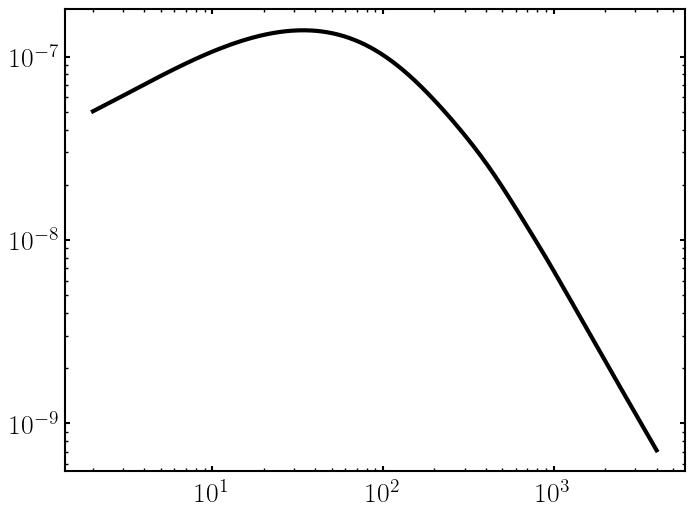

In [45]:
dust_type='d9'

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

for SKYFRAC in ['GAL060', 'GAL080']:
    ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)

#ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}'][:args.mlmax+1]*lfac)[2:], lw=5, color='crimson')
# ax.loglog(ell_arr[2:], (reconstructed_cl_d9[:args.mlmax+1]*lfac)[2:], color='crimson', linestyle='dashed', linewidth = 3, label='d9')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')
ax.legend()
####fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/patch_subtraction.png', bbox_inches='tight')
plt.show()

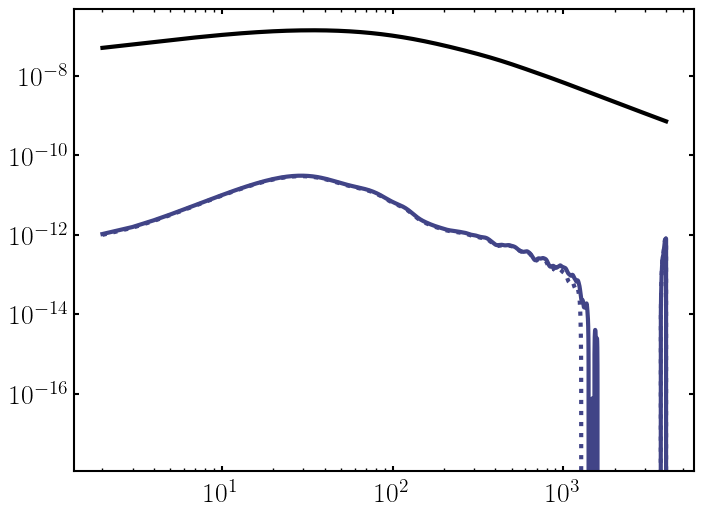

In [52]:
dust_type='d9'
SKYFRAC='GAL060'
TEST = 'lmin'
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmin10']['linestyle'], linewidth = 3, label=dust_type)
ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmin600']['linestyle'], linewidth = 3, label=dust_type)


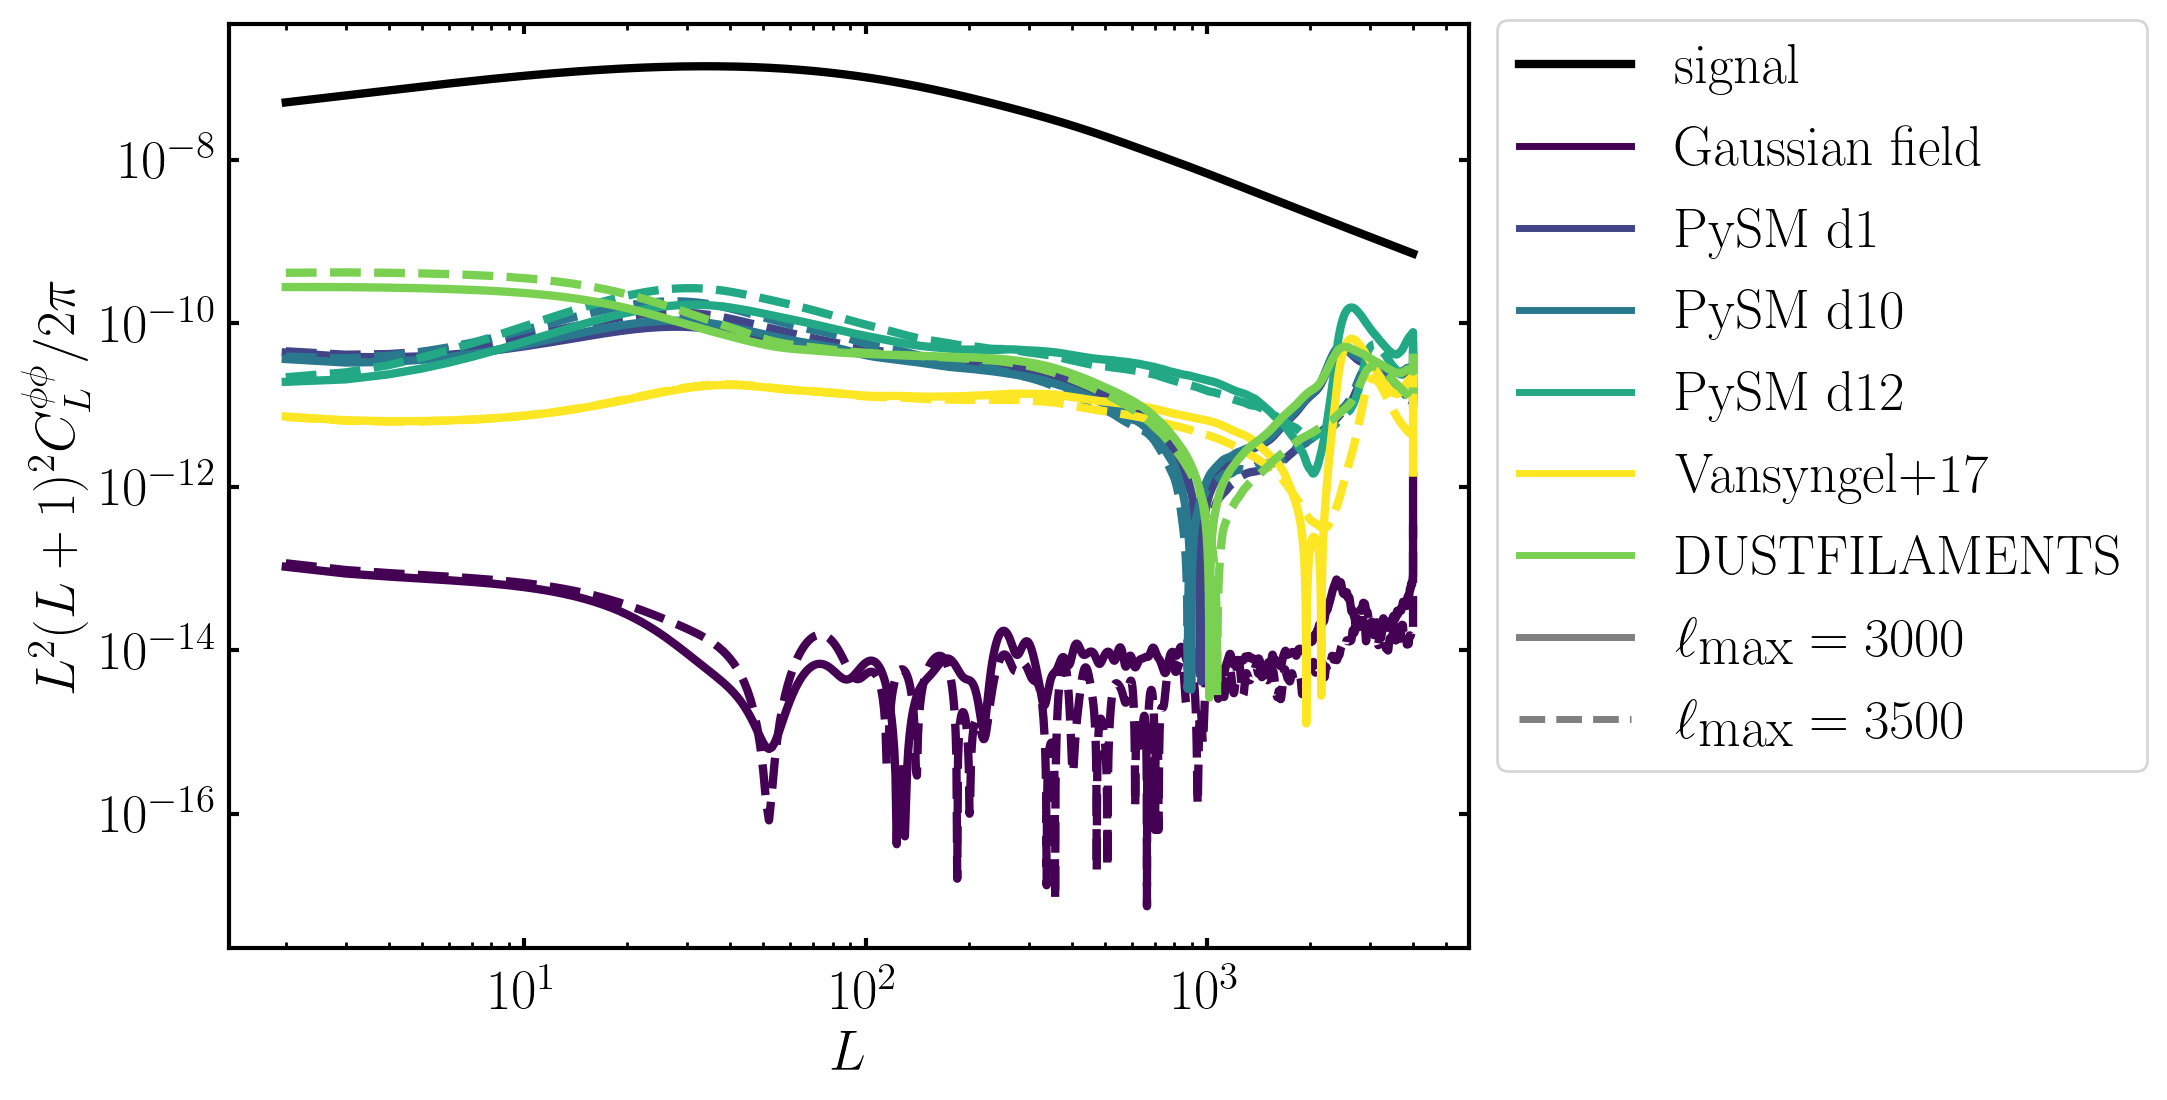

In [46]:
SKYFRAC='GAL070'
TEST = 'lmax'
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

for dust_type in autils.DUST_TYPES:
    
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmax3500']['linestyle'], linewidth = 3, label=dust_type)
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmax3000']['linestyle'], linewidth = 3, label=dust_type)


ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[f'lmax{lmax}']['linestyle'], lw=2.5) for lmax in [3000, 3500]]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES]
legend_lines3 = [dict_plot[f'lmax{lmax}']['label'] for lmax in [3000, 3500]]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.035), loc = 'upper left') # (1, 1.025)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$') 

fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/recons_baseline_lmax.png', bbox_inches='tight')

plt.show()

## 4pts by patch -- unit tests

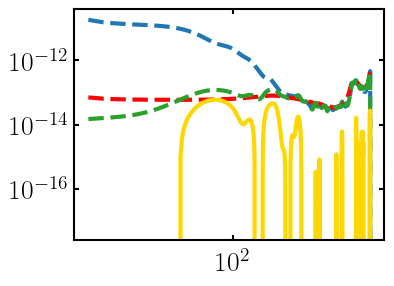

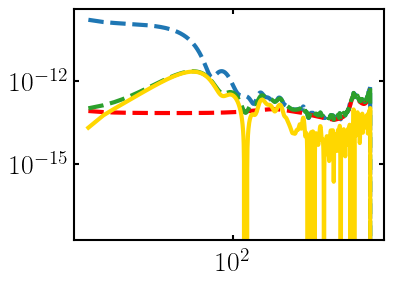

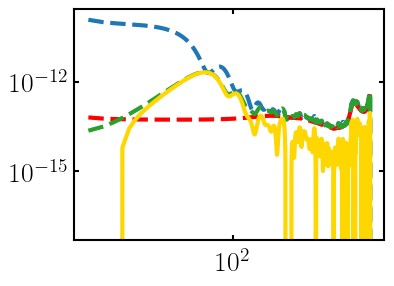

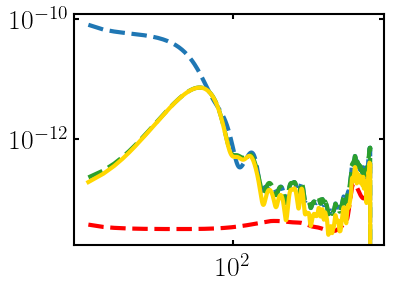

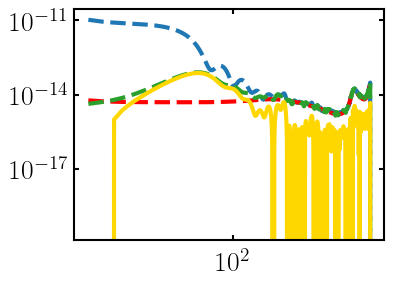

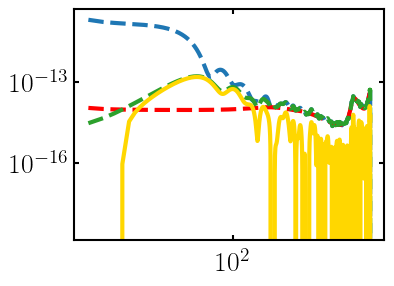

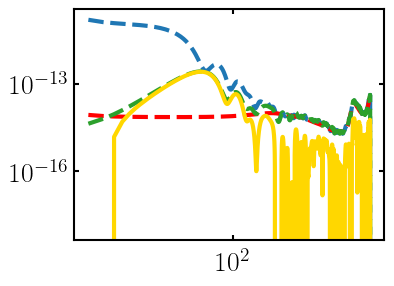

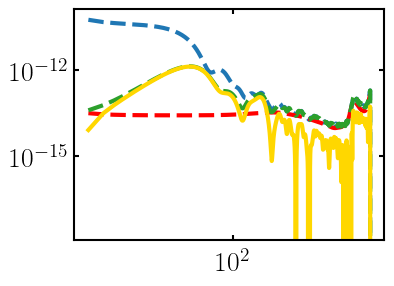

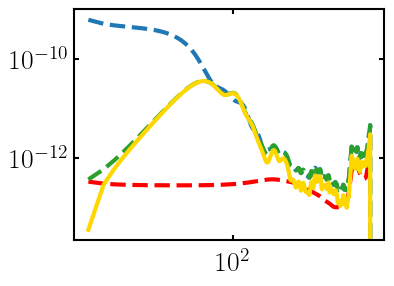

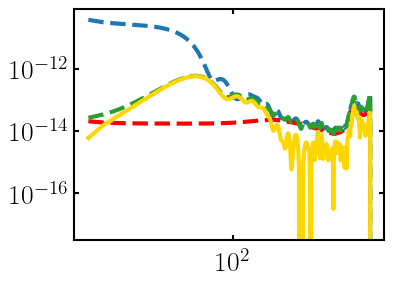

In [96]:
dust_type = 'd12'
SKYFRAC='GAL060'
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.loglog(ell_arr[2:], (raw_4pt[f'{dust_type}_{SKYFRAC}'][n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
    ax.loglog(ell_arr[2:], (n0_4pt[f'{dust_type}_{SKYFRAC}'][n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
    ax.loglog(ell_arr[2:], (rawmf_4pt[f'{dust_type}_{SKYFRAC}'][n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
    ax.loglog(ell_arr[2:], (cl_nobias[f'{dust_type}_{SKYFRAC}'][n][:args.mlmax+1]*lfac)[2:], color='gold', linestyle='solid', linewidth = 3, label='unbiased')

    plt.show()
    

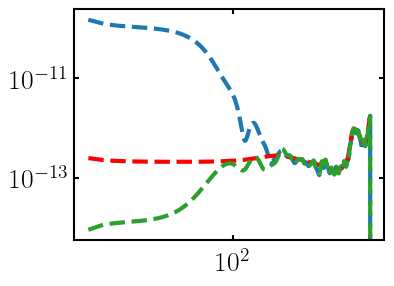

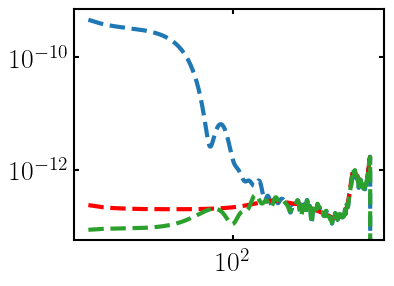

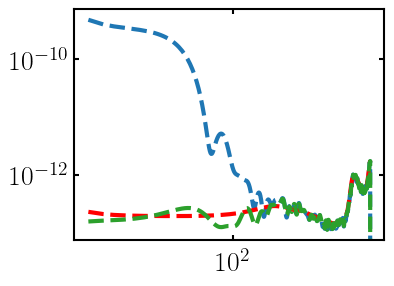

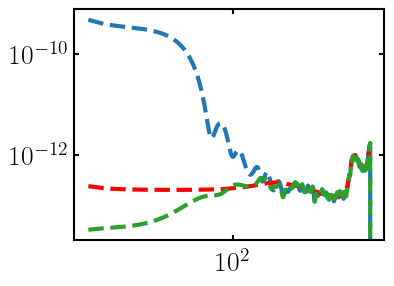

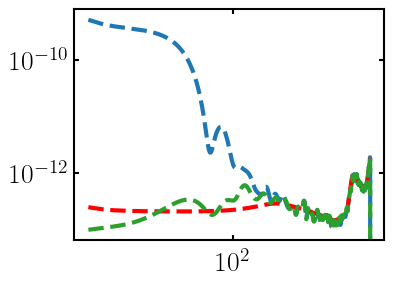

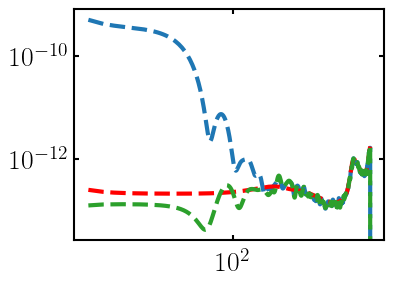

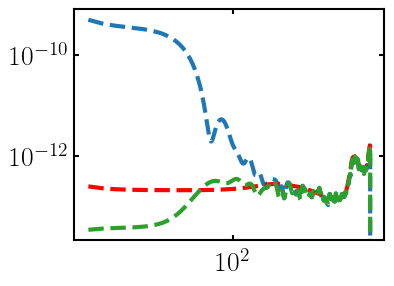

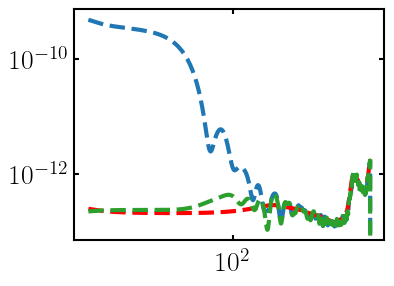

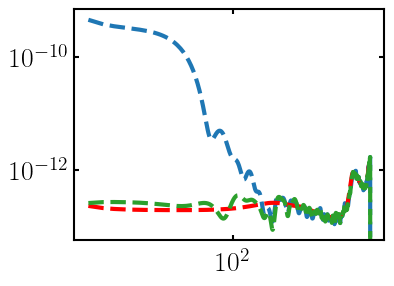

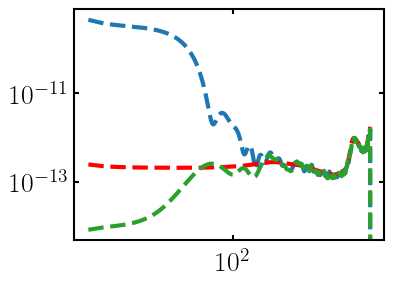

In [38]:
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.loglog(ell_arr[2:], (raw_4pt_g[n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
    ax.loglog(ell_arr[2:], (n0_2pt_g[n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
    ax.loglog(ell_arr[2:], (rawmf_4pt_g[n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')

    plt.show()

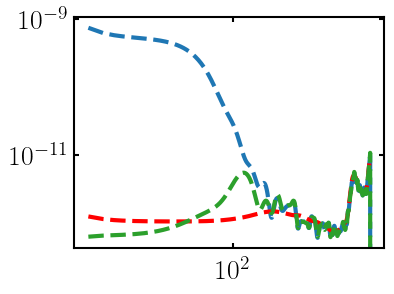

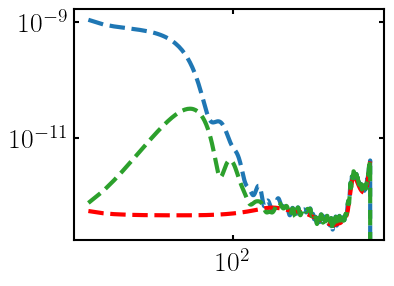

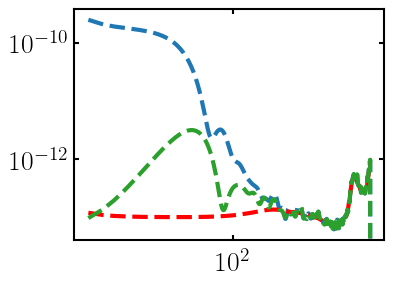

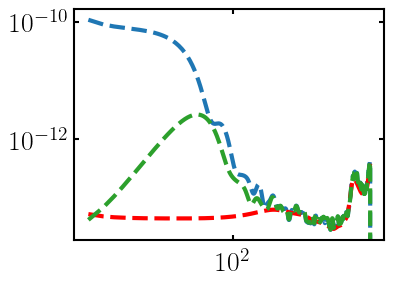

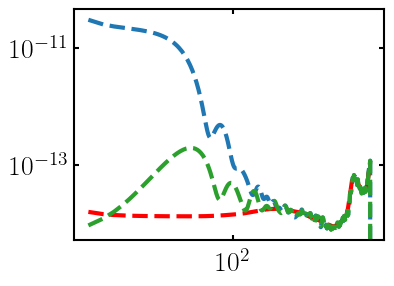

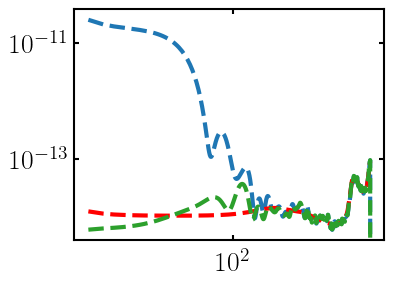

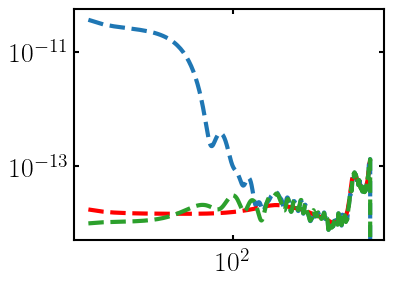

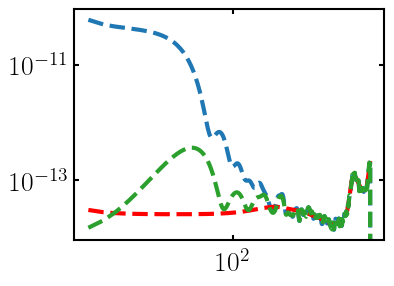

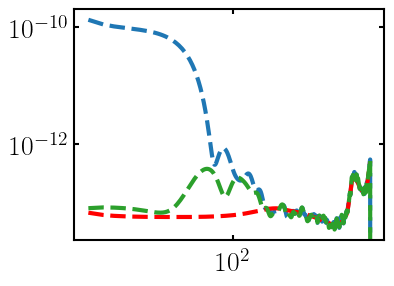

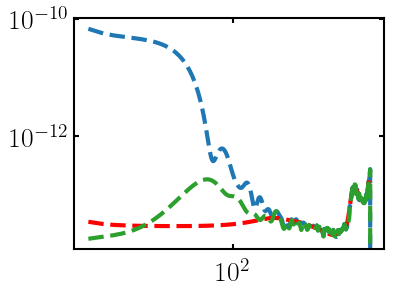

In [39]:
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.loglog(ell_arr[2:], (raw_4pt_d9[n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
    ax.loglog(ell_arr[2:], (n0_2pt_d9[n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
    ax.loglog(ell_arr[2:], (rawmf_4pt_d9[n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')

    plt.show()

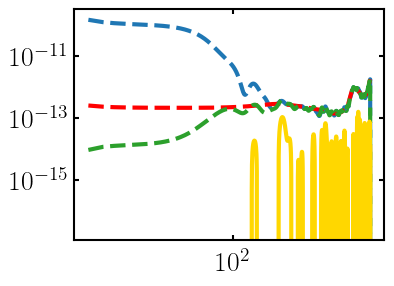

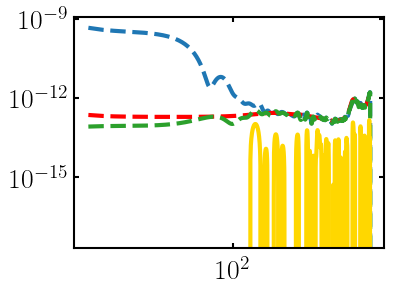

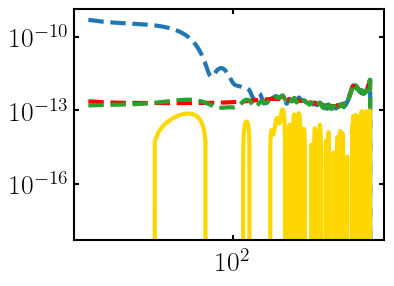

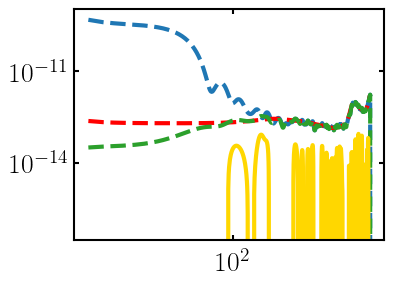

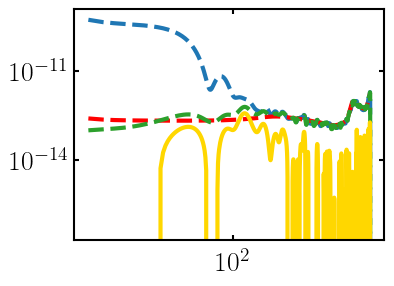

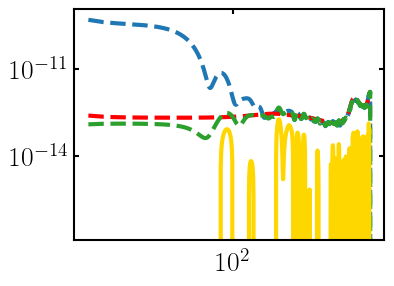

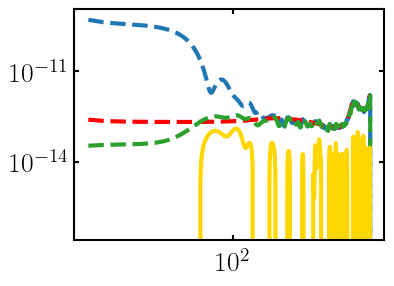

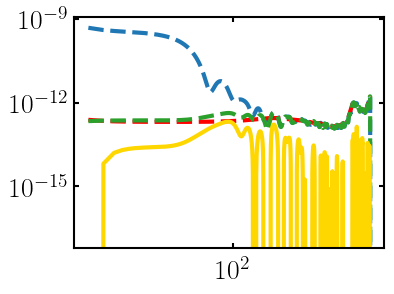

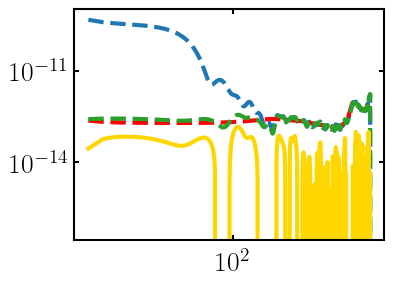

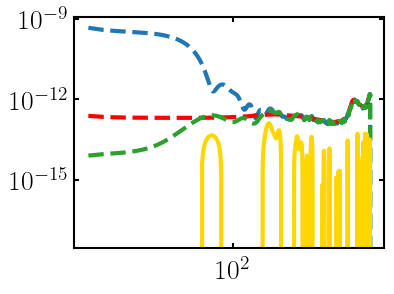

In [41]:
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.loglog(ell_arr[2:], (raw_4pt_g[n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
    ax.loglog(ell_arr[2:], (n0_2pt_g[n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
    ax.loglog(ell_arr[2:], (rawmf_4pt_g[n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
    ax.loglog(ell_arr[2:], (cl_nobias_g[n][:args.mlmax+1]*lfac)[2:], color='gold', linestyle='solid', linewidth = 3, label='unbiased')

    plt.show()

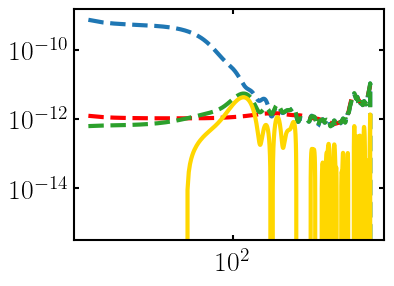

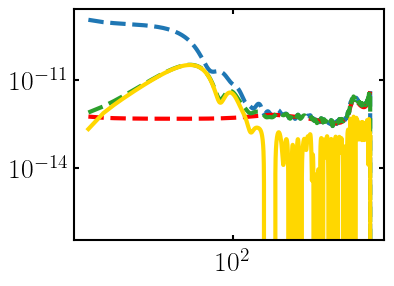

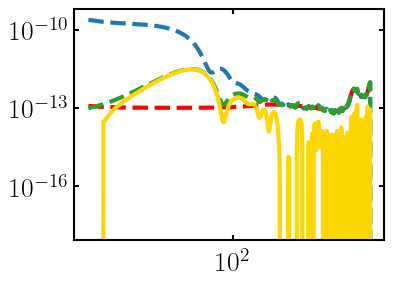

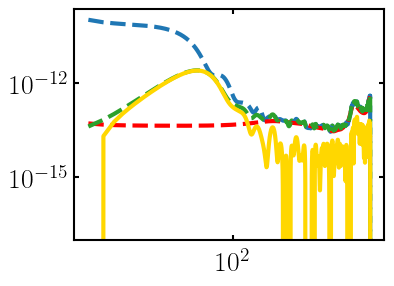

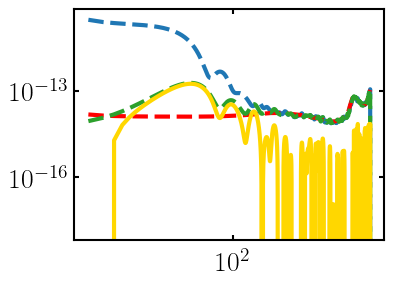

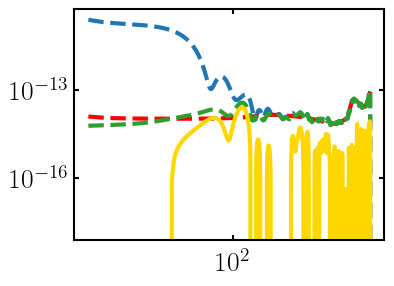

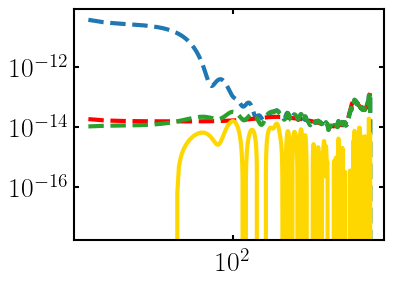

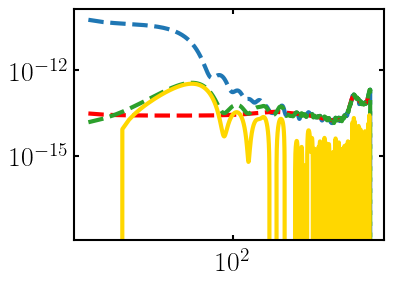

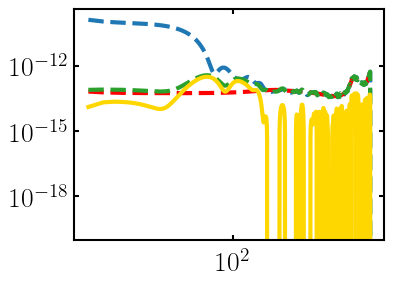

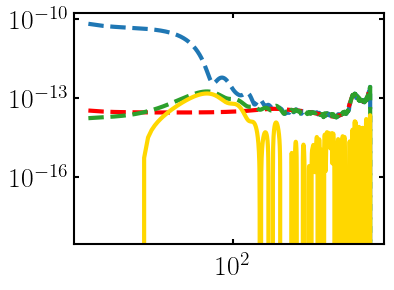

In [42]:
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.loglog(ell_arr[2:], (raw_4pt_d9[n][:args.mlmax+1]*lfac)[2:], color='tab:blue', linestyle='dashed', linewidth = 3, label='raw cl')
    ax.loglog(ell_arr[2:], (n0_2pt_d9[n][:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', color ='r', linewidth = 3, label='analytic N0')
    ax.loglog(ell_arr[2:], (rawmf_4pt_d9[n][:args.mlmax+1]*lfac)[2:], color='tab:green', linestyle='dashed', linewidth = 3, label='mf sub cl')
    ax.loglog(ell_arr[2:], (cl_nobias_d9[n][:args.mlmax+1]*lfac)[2:], color='gold', linestyle='solid', linewidth = 3, label='unbiased')

    plt.show()